In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("./")

In [3]:
import pyro
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Code
from sklearn.datasets import make_blobs
from utils import load_s_set_random_split, visualize

pyro.clear_param_store()
pyro.enable_validation(True)
pyro.set_rng_seed(707)

torch.manual_seed(707)

# Gaussian Mixture Models

GMMs is one of members of the Latent Variable Models family. Despite its name, it is a parameter-less model and latent variables are factors that describe the degree of a sample belonging to a particular cluster. These models are often used in clustering and classification. They can be also used as variational distributions in variational methods. Currently, many of bayesian hyperparameter optimization methods use them to define distribution over possible parameter values that can be sampled and that can provide better quality of a particular method.

Your task is to implement Gaussian Mixture Models using `pyro` capabilities (training and inference). We already provided necessary tools to visualize results. Note to meet requirements described in `__docs__` of each method to be implemented. 

More info can be found in: [1] _Machine Learning A Probabilistic Perspective_, Kevin Murphy, p. 337-342, 347-352 ([link](https://doc.lagout.org/science/Artificial%20Intelligence/Machine%20learning/Machine%20Learning_%20A%20Probabilistic%20Perspective%20%5BMurphy%202012-08-24%5D.pdf))


Example 2D gaussians with 3 components (p. 339) of [1]:

![2D example](example_2d.png)

## Data

You will work on two datasets: one that serves as a sanity check and the another as a final evaluation dataset. The latter is called S-Set and it contains over 10 clusters that were generated from the mixture of gaussian distributions. Note however, that the S-Set is considered to be "difficult", hence it can be impossible to find the "right" number of clusters.

### "Sanity check" dataset

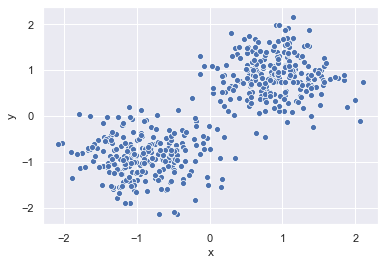

In [11]:
sc_train, _ = make_blobs(500, random_state=0, centers=((-2, -2), (2, 2)))
sc_train = torch.from_numpy(sc_train).float()
sc_train = (sc_train - sc_train.mean(dim=0)) / sc_train.std(dim=0)

sns.scatterplot("x", "y", data=pd.DataFrame(data={"x": sc_train[:, 0], "y": sc_train[:, 1]}))

### S-Set 

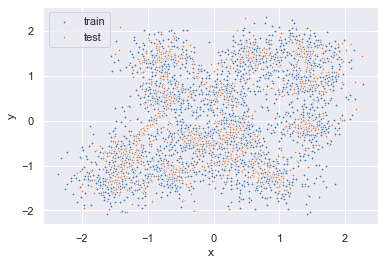

In [12]:
train, test = load_s_set_random_split()

ax = sns.scatterplot("x", "y", data=train, s=8, label="train")
sns.scatterplot("x", "y", data=test, s=8, ax=ax, label="test")
plt.legend()
plt.show()


train = torch.from_numpy(train.values).float()
test = torch.from_numpy(test.values).float()

mean = train.mean(dim=0)
std = train.std(dim=0)

train = (train - mean) / std
test = (test - mean) / std

The implementation should be performed in `gmm.py`.

## Implementing GMM

### Few notes on [`config_enumerate`](http://docs.pyro.ai/en/stable/poutine.html#pyro.infer.enum.config_enumerate) ...

Some people may want to use SVI to optimize latent variables. Care should be taken in that case since these latent variables (or so called assignment factors) are probabilities for the final assignment that follows categorical distribution. It comes from the fact that each sample is assumed to be generated from the particular gaussian. Since the categorical distribution does not have variational form, `config_enumerate` should be used. Generally, it makes the optimization with SVI more stable. Internally, it enumerates over all possible values that can be sampled from the categorical distribution and scales log likelihood gradients from each sampling branch, proportionately to the probability of sampling that branch. It follows the notion of Monte Carlo gradient approximation, commonly used in neural networks for example. To take advantage of the `config_enumerate`, you have to use `TraceEnum_ELBO()` as a loss in the SVI constructor.

More info in [this link](https://pyro.ai/examples/enumeration.html).

### Final notes on the implementation

In this task, you have to implement the following methods:
- `fit` method that takes training dataset and optimizes latent variables
- `predict_proba` that takes a dataset and outputs matrix $N \times K$ where $N$ is a number of samples and $K$ number of components. Each row of the matrix contains probabilities of a sample belonging to a particular component
- `score` that produces similar matrix as `predict_proba` but each entry contains negative log likelihood that the sample was produced by a particular gaussian
- `log_likelihood` calculates a single scalar describing how probable is that the dataset was produced by the used GMM (this can implemented using `poutine.trace` or manually)



In [13]:
display(Code("gmm.py"))

from __future__ import annotations

import abc
import typing as t

import pyro
import pyro.distributions as dist
import torch
from pyro import poutine
from pyro.infer import config_enumerate, SVI, TraceEnum_ELBO, infer_discrete
from pyro.infer.autoguide import AutoDelta

pyro.enable_validation(True)


def to_covariance_matrix(scales):
    return torch.stack(list(map(lambda t: torch.diag(t), scales)))


class MixtureModel(abc.ABC):
    def __init__(self, num_components: int):
        self.num_components = num_components
        self.history = {
            "loss": []
        }  # TODO: accumulate during training

    @abc.abstractmethod
    def fit(self, x: torch.Tensor) -> MixtureModel:
        """Fit posterior of k Gaussians and mixing components.

        :param x: N x D matrix of the input data points.
        :return: self
        """

    @abc.abstractmethod
    def predict_proba(self, x: torch.Tensor) -> torch.Tensor:
        """Predict assignment probabilities for the input points.

        :param x: N x D matrix of the input data points.
        :return: N x K matrix of probabilities where K is the number of mixing
            components of gaussians.
        """

    @abc.abstractmethod
    def log_likelihood(self, x: torch.Tensor) -> t.Union[float, torch.Tensor]:
        """Calculate log likelihood of determined posterior.

        :param x: N x D matrix of the input data points.
        :return: A scalar containing log likelihood.
        """

    @abc.abstractmethod
    def score(self, x: torch.Tensor):
        """Calculate negative log likelihood for each sample and component.

        :param x: N x D matrix of the input data points.
        :return: N x K matrix containing negative log likelihood of a sample
            being produced by each of the K components in the mixture model.
        """


class GaussianMixtureModel(MixtureModel):
    def __init__(self, num_components: int, optim_steps: int):
        super().__init__(num_components)
        self.optim_steps = optim_steps
        self.guide = None

    @config_enumerate
    def model(self, data):
        pyro.clear_param_store()
        K = self.num_components

        weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))

        with pyro.plate('components', K):
            locs = pyro.sample('locs', dist.Normal(torch.zeros(2), 2.).independent(1))
            scales = pyro.sample('scales', dist.LogNormal(torch.zeros(2), 3.).independent(1))
        scales = to_covariance_matrix(scales)

        with pyro.plate('data', data.shape[0]):
            assignment = pyro.sample('assignment', dist.Categorical(weights))
            obs = pyro.sample('obs',
                              dist.MultivariateNormal(locs[assignment], scales[assignment]),
                              obs=data)
        return obs

    def fit(self, x: torch.Tensor) -> MixtureModel:
        def init_loc_fn(site):
            K = self.num_components
            if site["name"] == "weights":
                return torch.ones(K) / K
            if site["name"] == "scales":
                return torch.tensor([[(x.var() / 2).sqrt()] * 2] * K)
            if site["name"] == "locs":
                return x[torch.multinomial(torch.ones(x.shape[0]) / x.shape[0], K), :]
            raise ValueError(site["name"])

        self.guide = AutoDelta(poutine.block(self.model, expose=['weights', 'locs', 'scales']),
                               init_loc_fn=init_loc_fn)

        optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
        loss = TraceEnum_ELBO(max_plate_nesting=1)

        svi = SVI(self.model, self.guide, optim, loss=loss)

        for i in range(self.optim_steps):
            elbo = svi.step(x)
            self.history["loss"].append(elbo)
        return self

    def predict_proba(self, x: torch.Tensor) -> torch.Tensor:
        K = self.num_components
        trace = self.get_infered_model_trace(x)
        probs = torch.zeros((x.shape[0], K))
        for i, v in en

In [14]:
from gmm import GaussianMixtureModel

#### Sanity check dataset

In [15]:
gaussian_mixture_model = GaussianMixtureModel(num_components=2, optim_steps=500)

In [16]:
gaussian_mixture_model.fit(sc_train)

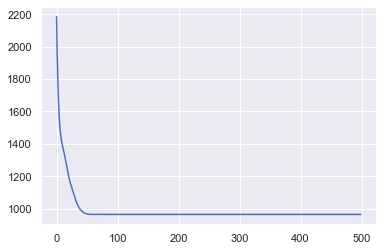

In [17]:
nll = gaussian_mixture_model.history["loss"]
plt.plot(range(len(nll)), nll)

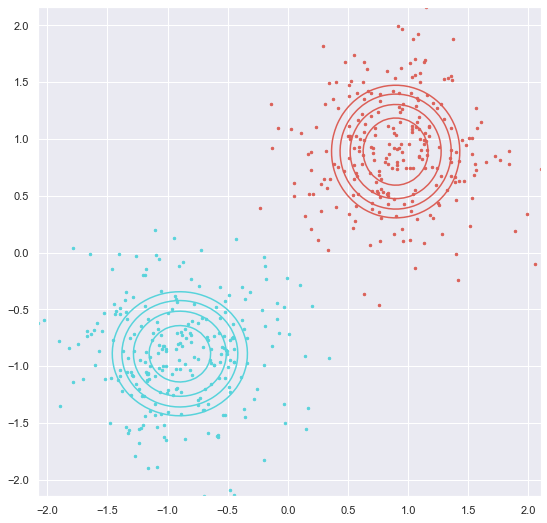

In [18]:
visualize(gaussian_mixture_model, sc_train)

In [19]:
"Log likelihood: {:.4f}".format(gaussian_mixture_model.log_likelihood(test))

'Log likelihood: -3129.9934'

#### S-Set

In [24]:
gaussian_mixture_model = GaussianMixtureModel(optim_steps=500, num_components=12)

In [25]:
gaussian_mixture_model.fit(train)

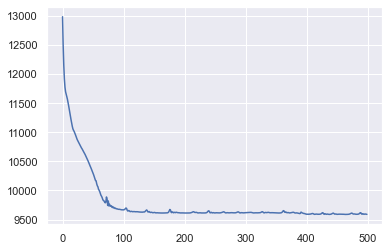

In [26]:
nll = gaussian_mixture_model.history["loss"]
plt.plot(range(len(nll)), nll)

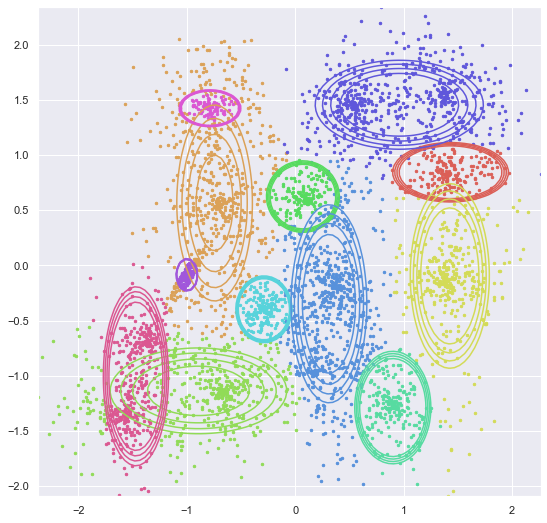

In [27]:
visualize(gaussian_mixture_model, train)

In [377]:
"Log likelihood: {:.4f}".format(gaussian_mixture_model.log_likelihood(test))

'Log likelihood: -1962.3901'